In [2]:
import os
import h5py
import torch
from torch.utils.data import Dataset
from glob import glob

class HDF5ChunkedDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        PyTorch Dataset for reading chunked HDF5 files.

        Args:
            root_dir (str): Path to directory containing HDF5 chunks.
            transform (callable, optional): Optional transform to apply to each sample.
        """
        self.chunk_files = sorted(glob(os.path.join(root_dir, '*.h5')))
        self.transform = transform
        self.index_map = []

        self.chunk_sizes = []
        for chunk_idx, file in enumerate(self.chunk_files):
            with h5py.File(file, 'r') as f:
                n_samples = f['x'].shape[0]
                self.chunk_sizes.append(n_samples)
                self.index_map.extend([(chunk_idx, i) for i in range(n_samples)])

    def __len__(self):
        return len(self.index_map)

    def __getitem__(self, idx):
        chunk_idx, local_idx = self.index_map[idx]
        file_path = self.chunk_files[chunk_idx]

        with h5py.File(file_path, 'r') as f:
            image = f['x'][local_idx]
            birads = f['y_birads'][local_idx]
            lesion = f['y_lesions'][local_idx]

        # Normalize or convert to torch tensor
        image = torch.tensor(image, dtype=torch.float32).unsqueeze(0)  # Assuming grayscale
        birads = torch.tensor(birads, dtype=torch.long)
        lesion = torch.tensor(lesion, dtype=torch.long)

        if self.transform:
            image = self.transform(image)

        return image, {'birads': birads, 'lesion': lesion}


In [5]:
val_path = '/media/nvidia/DATA2/datasets/prepared/vindr/1024_cropped/train'

test_dataset = HDF5ChunkedDataset(root_dir=val_path, transform=None)
sample = test_dataset[0]

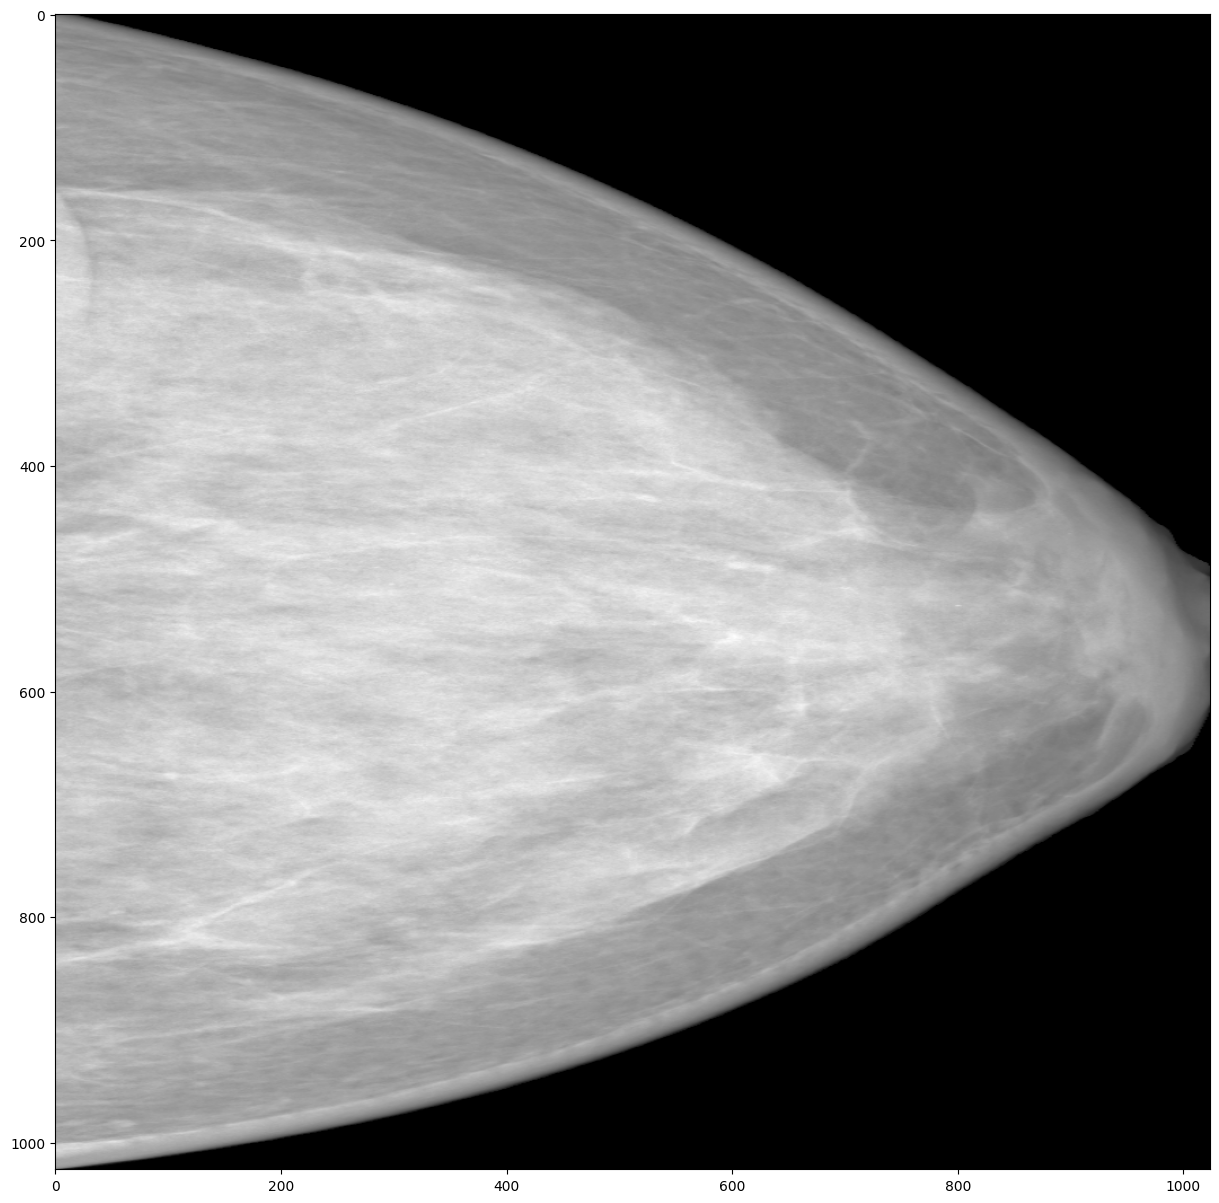

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 15))
plt.imshow(sample[0][0], cmap='gray')
plt.show()